# Predicting the Number of Health Plan Options in a Given County

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import BaggingRegressor

In [2]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

## The Data

In [4]:
# Set paths and file names

projpath='C:\\Users\\l_gas\\Documents\\Development\\SpringBoard_DataScience\\CapstoneProj1'

# Read analytic file with regional population measures and merge with party affiliation data
plans_data = (pd.read_json("./plans_data.json"))

plans_data.head()

,fips,count_plans,count_issuers,state,st,fips_st,fips_county,CBSA,CBSA_Name,CBSA_Ind,CBSA_Status,Num_Hosp2017,Pop2017,MedIncome2017,IndMarketEnroll2017,Unemployment,State Code,Pparty,Market_Reg,fips_str
0,1001,7,1,Alabama,AL,1,1,33860.0,"Montgomery, AL Metro SA",1,Central,1,55504,58343,1705,3.9,AL,Republican,Federal,1001
1,1003,7,1,Alabama,AL,1,3,19300.0,"Daphne-Fairhope-Foley, AL Metro SA",1,Central,4,212628,56607,11367,4.0,AL,Republican,Federal,1003
2,1005,7,1,Alabama,AL,1,5,21640.0,"Eufaula, AL-GA Micro SA",2,Central,1,25270,32490,738,5.9,AL,Republican,Federal,1005
3,1007,7,1,Alabama,AL,1,7,13820.0,"Birmingham-Hoover, AL Metro SA",1,Outlying,1,22668,45795,516,4.4,AL,Republican,Federal,1007
4,1009,7,1,Alabama,AL,1,9,13820.0,"Birmingham-Hoover, AL Metro SA",1,Outlying,1,58013,48253,2062,4.0,AL,Republican,Federal,1009


In [5]:
## SET THE MATICES TO FIT A MODEL FOR NUMBER OF PLANS AVAILABLE AT THE COUNTY LEVEL
def label_ind (row):
   if row['CBSA_Ind'] == 0 :
      return 'Not a CBSA'
   if row['CBSA_Ind'] == 1 :
      return 'MetroCBSA'
   if row['CBSA_Ind'] == 2 :
      return 'MicroCBSA'

cbsa_type = plans_data.apply (lambda row: label_ind(row), axis=1)

XP_raw = pd.DataFrame(data={'cbsa_type': cbsa_type, 'pop': plans_data.Pop2017, 'medinc': plans_data.MedIncome2017, 'enrol': plans_data.IndMarketEnroll2017,
                            'unemp': plans_data.Unemployment, 'state': plans_data.state, 'Pparty': plans_data.Pparty, 'hosp': plans_data.Num_Hosp2017,'Issuer': plans_data.count_issuers})
YP = plans_data[['count_plans']]

# Generate dumies from categorical variables and drop one level to avoid colinearity. 
XP = pd.get_dummies(XP_raw)
XP = XP.drop(['state_Texas','cbsa_type_MetroCBSA','Pparty_Republican'],axis=1)


## PREDICTING NUMBER OF PLAN OPTIONS AVAILABLE IN A MARKET

### Testing Linear Regression Using a Cross-validation Approach

We use a linear regression approach to predict the number of plans faced by consumers in the individual health insurance market. We explore using a model penalizing the number of explanatory variables used, like the Ridge regression or Lasso regression. We split the model into a training and test set. We use the training set to evaluate the three alternatives using cross validation with 3-folds. Then we use the test set to evaluate the selected model fit.

In [6]:
# Apply Cross Validation to the Linear Regression Fit - Explore aternative models penalizing for number of variables included
# in the model: Ridge and Lasso regression 

XP_train, XP_test, YP_train, YP_test = train_test_split(XP.to_numpy(), YP.to_numpy(), test_size = 0.3, random_state = 42)

#XP_train, XP_test, YP_train, YP_test = train_test_split(XP, YP, test_size = 0.3, random_state = 42)

print("Table 2")
print("CROSS VALIDATION - EVALUATION ON THE TRAINING SET")
print("LINEAR REGRESSION")
reg=LinearRegression()
cv_scr = cross_validate(reg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr['test_neg_mean_squared_error'].mean()*-1,2*cv_scr['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr['test_r2'].mean(),2*cv_scr['test_r2'].std()))

print("RIDGE REGRESSION")
rdgreg=Ridge()
cv_scr_rdg = cross_validate(rdgreg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_neg_mean_squared_error'].mean()*-1,2*cv_scr_rdg['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr_rdg['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_r2'].mean(),2*cv_scr_rdg['test_r2'].std()))

print("LASSO REGRESSION")
lssreg=Lasso()
cv_scr_lss = cross_validate(lssreg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_neg_mean_squared_error'].mean()*-1,2*cv_scr_lss['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr_lss['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_r2'].mean(),2*cv_scr_lss['test_r2'].std()))


Table 2
CROSS VALIDATION - EVALUATION ON THE TRAINING SET
LINEAR REGRESSION
Mean Squared Error: 22.84  (+/- 9.86)
Mean Absolute Error: 2.68  (+/- 0.12)
R2: 0.77  (+/- 0.02)
RIDGE REGRESSION
Mean Squared Error: 23.02  (+/- 11.14)
Mean Absolute Error: 2.68  (+/- 0.14)
R2: 0.77  (+/- 0.02)
LASSO REGRESSION
Mean Squared Error: 55.75  (+/- 25.28)
Mean Absolute Error: 5.06  (+/- 0.37)
R2: 0.44  (+/- 0.03)


For a linear regression model we can use the R2 and the mean absolute error (MAE) to evaluate the fit. The R2 shows the proportion of the dependent variable variance explained by the model. When comparing two models, a higher R2 implies the model has better predictive power. The MAE is a measure of the model's predicted power. A lower absolute error implies the model has better predictive power. 

When comparing the three linear regression options tested, the Lasso regression clearly doesn't do a good job and the other two have very similar scores (within the 95% confidence interval). The average MSE obtained with the linear fit is slightly better than the Ridge regression (though not statistically different), and since the linear regression is widely used, the first inclination is to chose the linear regression model.

An additional test can be run for the selected model using the test set we extracted before. Besides the R2 and the mean absolute error, we can also construct an accuracy measure based on an absolute desired maximum error. In this case we are trying to predict the number of plans offered, with an average level of 14.5. We can set the maximum error at 3 plans, about 20% of the mean.  

In [7]:
reg.fit(XP_train,YP_train)
print('Table 3')
print("LINEAR REGRESSION EVALUATION ON TEST SET")
print("Mean Squared Error %0.2f" % mean_squared_error(YP_test, reg.predict(XP_test)))
print("Mean Absolute Error %0.2f" % mean_absolute_error(YP_test, reg.predict(XP_test)))
print("R2: %0.2f" % r2_score(YP_test, reg.predict(XP_test)))
large_error = abs(YP_test-reg.predict(XP_test))>3
perc_lrgerror = large_error.sum()/len(large_error)*100
print("Percent of counties with an absolute error larger than 3: %0.2f" % perc_lrgerror)

Table 3
LINEAR REGRESSION EVALUATION ON TEST SET
Mean Squared Error 31.71
Mean Absolute Error 3.05
R2: 0.77
Percent of counties with an absolute error larger than 3: 31.25


In [8]:
print("FINAL FIT USING FULL DATA SET")
reg.fit(XP,YP)
print("Mean Squared Error %0.2f" % mean_squared_error(YP, reg.predict(XP)))
print("Mean Absolute Error %0.2f" % mean_absolute_error(YP, reg.predict(XP)))
print("R2: %0.2f" % r2_score(YP, reg.predict(XP)))
large_error = abs(YP_test-reg.predict(XP_test))>3
perc_lrgerror = large_error.sum()/len(large_error)*100
print("Counties with an absolute error larger than 3: %0.2f" % perc_lrgerror,"%")

FINAL FIT USING FULL DATA SET
Mean Squared Error 23.61
Mean Absolute Error 2.74
R2: 0.79
Counties with an absolute error larger than 3: 29.66 %


In [9]:
params = pd.Series(list(reg.coef_)[0],index=XP.columns)
print(params)

pop                     -0.000004
medinc                  -0.000059
enrol                    0.000043
unemp                   -0.087184
hosp                     0.120328
Issuer                  10.217068
cbsa_type_MicroCBSA     -0.561440
cbsa_type_Not a CBSA    -1.249342
state_Alabama            1.117663
state_Alaska             0.725460
state_Arizona           -0.099578
state_Arkansas          -8.081260
state_Delaware           4.200008
state_Florida           17.886096
state_Georgia            6.496211
state_Hawaii             9.692978
state_Illinois          10.670186
state_Indiana           10.462930
state_Iowa               1.230461
state_Kansas            -3.318220
state_Kentucky           5.739134
state_Louisiana         -5.172143
state_Maine              0.487600
state_Michigan         -11.993148
state_Mississippi       -0.657040
state_Missouri           5.682006
state_Montana           -7.319835
state_Nebraska           2.328895
state_Nevada            -0.569130
state_New Hamp

## Using Decision Trees and Ensemble Methods

### Single Decision Tree

In [10]:
# Fit Single Decision Tree

from sklearn import tree
#from sklearn.tree import export_graphviz
#import IPython, graphviz, re, math

# Train the Model
XP_train, XP_test, YP_train, YP_test = train_test_split(XP.to_numpy(), YP.to_numpy(), test_size = 0.3, random_state = 11)

dt_mod = tree.DecisionTreeRegressor(max_leaf_nodes=5)
dt_mod.fit(XP_train,YP_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

['DecisionTreeClassifier', 'DecisionTreeRegressor', 'ExtraTreeClassifier', 'ExtraTreeRegressor', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_criterion', '_reingold_tilford', '_splitter', '_tree', '_utils', 'export', 'export_graphviz', 'export_text', 'plot_tree', 'tree']


[Text(167.4, 195.696, 'Issuer <= 1.5\nentropy = 105.659\nsamples = 1902\nvalue = 14.356'),
 Text(111.60000000000001, 152.208, 'entropy = 20.194\nsamples = 1058\nvalue = 8.929'),
 Text(223.20000000000002, 152.208, 'state_Florida <= 0.5\nentropy = 129.582\nsamples = 844\nvalue = 21.16'),
 Text(167.4, 108.72, 'Issuer <= 4.5\nentropy = 89.028\nsamples = 816\nvalue = 20.205'),
 Text(111.60000000000001, 65.232, 'state_Wisconsin <= 0.5\nentropy = 68.977\nsamples = 780\nvalue = 19.406'),
 Text(55.800000000000004, 21.744, 'entropy = 47.089\nsamples = 738\nvalue = 18.642'),
 Text(167.4, 21.744, 'entropy = 263.044\nsamples = 42\nvalue = 32.833'),
 Text(223.20000000000002, 65.232, 'entropy = 210.528\nsamples = 36\nvalue = 37.5'),
 Text(279.0, 108.72, 'entropy = 509.786\nsamples = 28\nvalue = 49.0')]

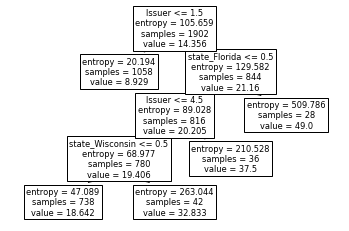

In [11]:
print(dir(tree))
tree.plot_tree(dt_mod,feature_names=XP.columns)

In [12]:
# Use the Model to Predict the Test set and Evaluate the fit
YP_test_pred = dt_mod.predict(XP_test)

# Calculate the errors
errors = YP_test_pred.reshape(len(YP_test_pred),1) - YP_test

# Print R2
print("R2 %0.2f" % dt_mod.score(XP_test, YP_test))

# Print the mean squared error (MSE) in number of plans unit
print("Mean Squared Error %0.2f" % (errors**2).mean())
print("Mean Absolute Error %0.2f" % abs(errors).mean())

# Consider an error larger than 3 (3 plan options) to be a large error (20% of the mean)
lrg_error = abs(errors)>=3
perc_lrg_errors = sum(lrg_error)/len(lrg_error)*100
print('Counties with an absolute error of 3 or more: %2.0f' % perc_lrg_errors,"%")


R2 0.55
Mean Squared Error 56.55
Mean Absolute Error 5.12
Counties with an absolute error of 3 or more: 57 %


### Random Forest Regression

In [13]:
# Fit Random Forest Regression

# Train the Model
XP_train, XP_test, YP_train, YP_test = train_test_split(XP.to_numpy(), YP.to_numpy(), test_size = 0.3, random_state = 11)

rf_mod = RandomForestRegressor(n_estimators = 100, max_features='auto', random_state = 42)
rf_mod.fit(XP_train,YP_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

unemp                   0.026461
state_Indiana           0.027222
state_South Carolina    0.029047
state_Illinois          0.029833
enrol                   0.031522
medinc                  0.031569
pop                     0.035251
state_Wisconsin         0.054816
state_Florida           0.116378
Issuer                  0.500139
dtype: float64


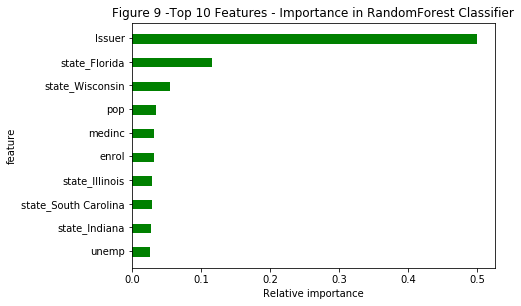

<Figure size 360x360 with 0 Axes>

In [14]:
#modelname.feature_importance_
y_fi = pd.Series(rf_mod.feature_importances_,index=XP.columns)
y_fi_top10 = y_fi.sort_values()[-10:]
print(y_fi_top10)
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y_fi_top10)) # the x locations for the groups
ax.barh(ind, y_fi_top10, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(y_fi_top10.index, minor=False)
plt.title('Figure 9 -Top 10 Features - Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.savefig("In Depth-RandomForestFeatures.png")


In [15]:
# Use the Model to Predict the Test set and Evaluate the fit

YP_test_pred = rf_mod.predict(XP_test)
# Calculate the errors
errors_rf = YP_test_pred.reshape(len(YP_test_pred),1) - YP_test

print("Table 4")
print('RANDOM FOREST EVALUATION ON TEST SET')
# Print R2
print("R2 %0.2f" % rf_mod.score(XP_test, YP_test))

# Print the mean squared and absolute error (MSE and MAE) in number of plans unit
print("Mean Squared Error %0.2f" % (errors_rf**2).mean())
print("Mean Absolute Error %0.2f" % abs(errors_rf).mean())

# Consider an error larger than 3 (3 plan options) to be a large error (20% of the mean)
lrg_error_rf = abs(errors_rf)>=3
perc_lrg_errors_rf = sum(lrg_error_rf)/len(lrg_error_rf)*100
print('Counties with an absolute error of 3 or more: %2.0f' % perc_lrg_errors_rf,"%")

Table 4
RANDOM FOREST EVALUATION ON TEST SET
R2 0.86
Mean Squared Error 17.46
Mean Absolute Error 2.06
Counties with an absolute error of 3 or more: 23 %


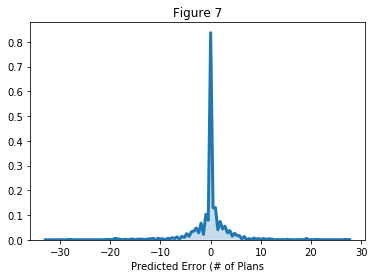

In [16]:
# distribution of errors
_ = sns.distplot(errors_rf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.title("Figure 7")
_ = plt.xlabel("Predicted Error (# of Plans")

plt.savefig("In Depth-RandomForestError.png")
